# QBio REU Intermediate Python

## Week 5: PCA with Scikit Learn

Prepared by John Russell (johnrussell@g.harvard.edu)

July 2020

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

#These are some matplot lib configurations that I like to use. 
mpl.rc("text", usetex=True) #if you have Latex set this to true and matplotlib will render labels in latex
mpl.rc("font", family = "serif") #Serif font in matplotlib
mpl.rc("figure",figsize=(9,6)) #Increase default figure size
%config InlineBackend.figure_format = 'retina' #If you have a high res display, render the plots more nicely
mpl.style.use('dark_background') #Use a dark background for matplotlib figures if youre using dark theme
plt.rcParams.update({"figure.facecolor": "111111",
                    "savefig.facecolor": "212121"})

In [58]:
import glob
import pandas as pd

### Overview of PCA

Principal component analysis (PCA) is a fundamental and widely used technique in machine learning. There are several equivalent ways to think about it but one way is to say that PCA reveals which direcitons in the space of our data are "important" or most descriptive of the data. We'll look at a toy example and then a more real case.

In [59]:
#generate some data
mean = [0,0]
off_diag = .9
cov = [[1.5,off_diag],[off_diag,1.5]]
pts = np.random.multivariate_normal(mean, cov, size=300)

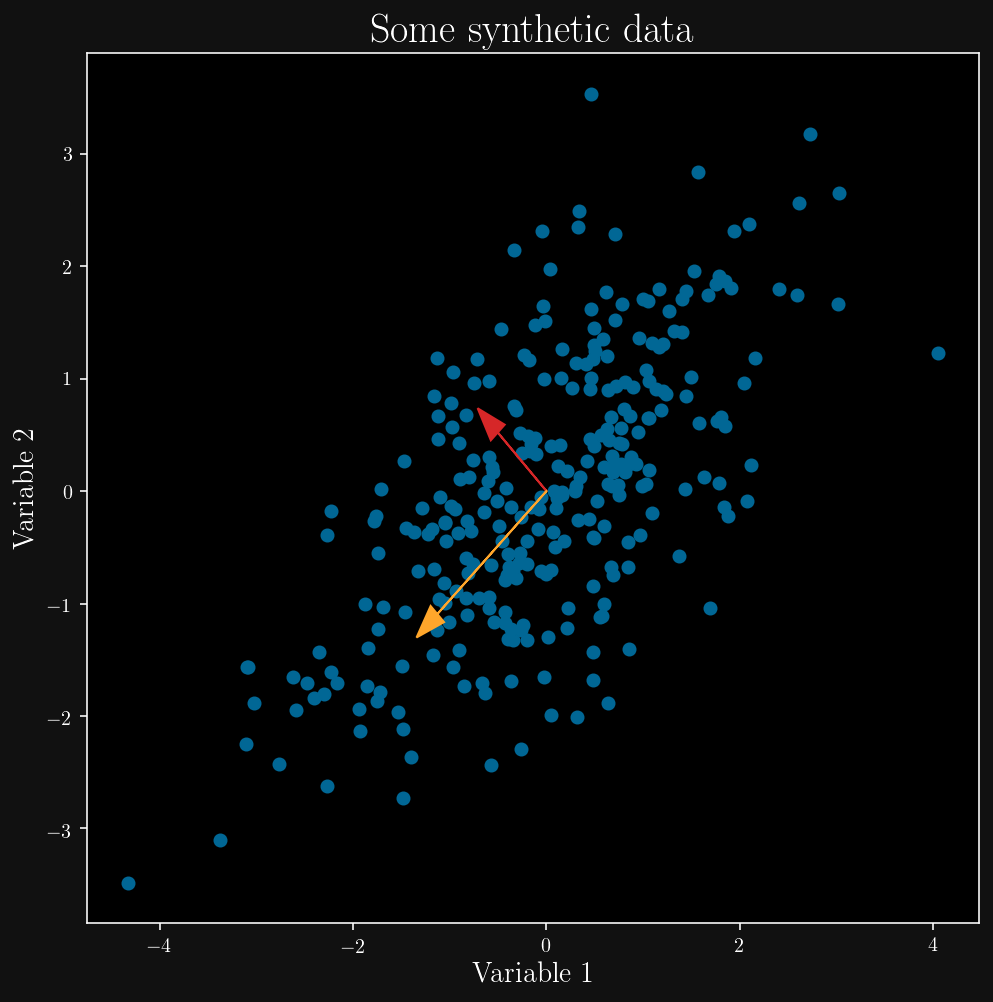

In [60]:
#don't worry about this line. It turns out this is what is happening under the hood during PCA
# I use this in order to be able to plot the arrows
vals,vecs = np.linalg.eigh(np.cov(pts.T))

plt.figure(figsize=(8,8))
plt.scatter(pts[:,0],pts[:,1], c='xkcd:peacock blue')
plt.title("Some synthetic data", fontsize=20)
plt.xlabel("Variable 1",fontsize=14)
plt.ylabel("Variable 2",fontsize=14)
head_width = .2
plt.arrow(mean[0],mean[1],-np.sqrt(vals[0])*vecs[0,0],-np.sqrt(vals[0])*vecs[1,0],
          head_width=head_width,fc='tab:red', ec='tab:red')
plt.arrow(mean[0],mean[1],np.sqrt(vals[1])*vecs[0,1], np.sqrt(vals[1])*vecs[1,1],
          head_width=head_width,fc='xkcd:mango', ec='xkcd:mango')
plt.show()

In [5]:
from sklearn.decomposition import PCA

In [63]:
pca = PCA(n_components=2)

In [64]:
fake_data_pcs = pca.fit_transform(pts)

In [67]:
fake_data_pcs.shape

(300, 2)

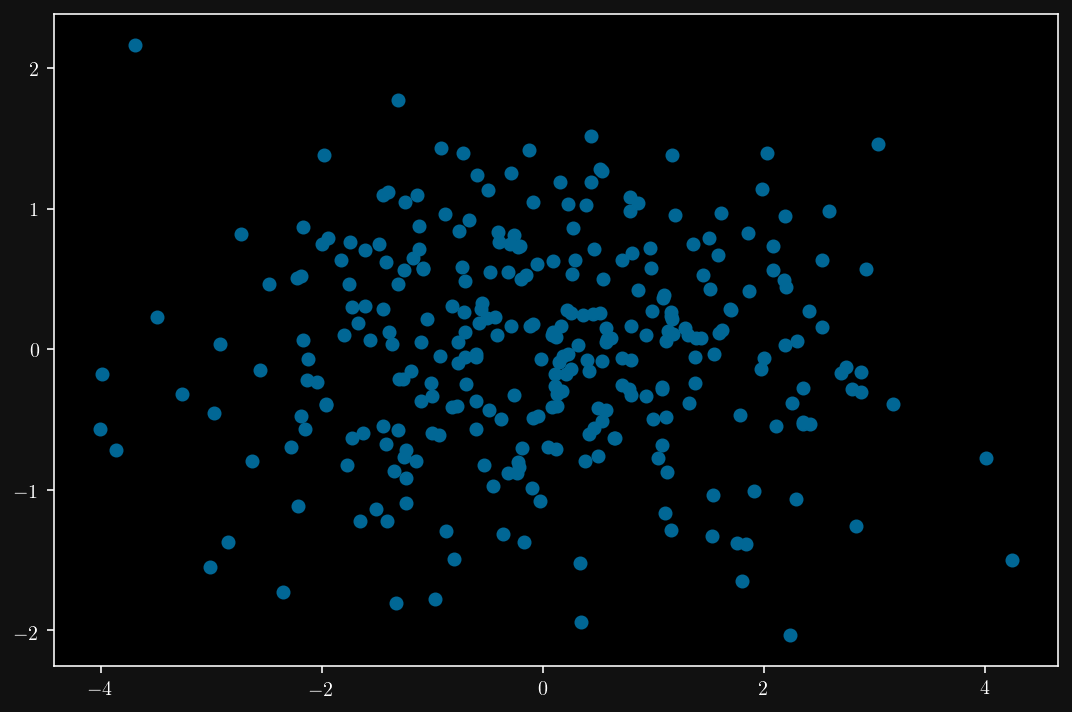

In [9]:
plt.scatter(fake_data_pcs[:,0],fake_data_pcs[:,1],c='xkcd:peacock blue')
plt.show()

#### PCA to visualize higher dimensional data

Oftentimes, data is high dimensional but we expect many of those dimensions to be useless for our understanding. PCA will pick out the best directions and, among other things, allow us to visualize the important parts of high dimensional datasets.

In [10]:
# cell to create toy high dimensional data
mean1 = [.7,0,0]
off_diag1 = 0.005
off_diag2 = 0
cov1 = [[.4,off_diag1,off_diag2],
       [off_diag1,.04,off_diag1],
       [off_diag2, off_diag1,.001]]
pts1 = np.random.multivariate_normal(mean1, cov1, size=300)
print('1 good')
mean2 = [-.5,0,0]
off_diag1 = -0.05
off_diag2 = 0
cov2 = [[.1,off_diag1,off_diag2],
       [off_diag1,.8,off_diag1],
       [off_diag2, off_diag1,.005]]
pts2 = np.random.multivariate_normal(mean2, cov2, size=300)
print('2 good')
points = np.concatenate([pts1,pts2],axis=0)

1 good
2 good


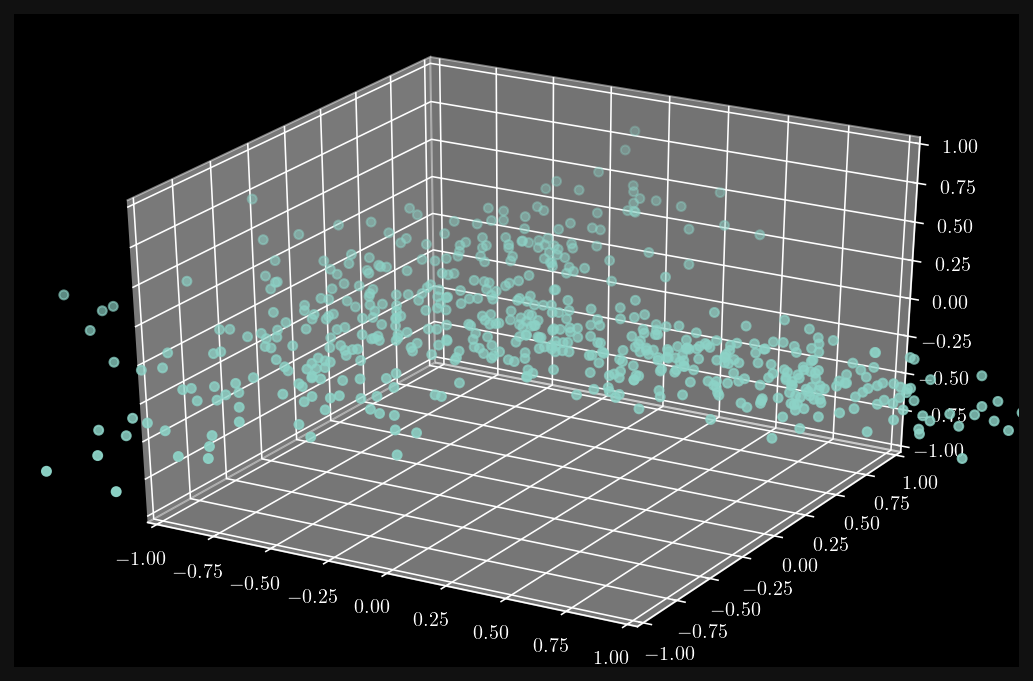

In [11]:
# This is how to make a 3d plot in matplotlib
# I google "matplotlib 3d plot" every single time i do this
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(points[:,0],points[:,1],points[:,2])
ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
plt.show()

In [68]:
pca = PCA(n_components=3)
transformed = pca.fit_transform(points)

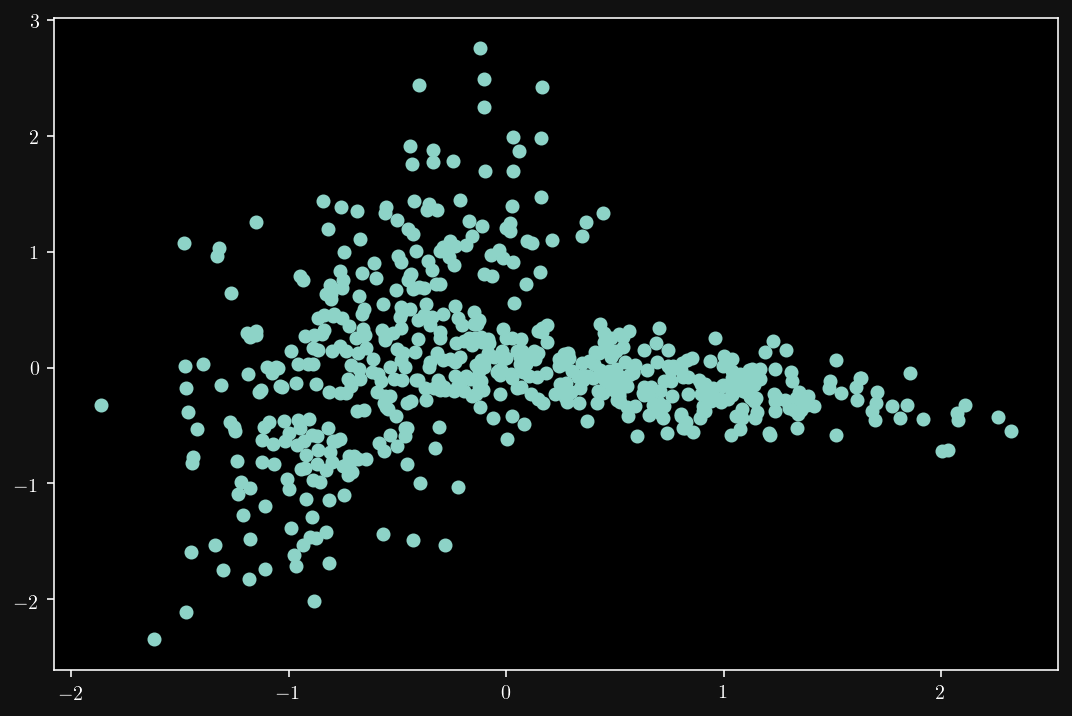

In [69]:
plt.scatter(transformed[:,0], transformed[:,1])
plt.show()

In [14]:
pca.explained_variance_ratio_

array([0.58569655, 0.41258906, 0.00171439])

In [70]:
pca.components_

array([[ 0.97972531, -0.20012734,  0.00934725],
       [-0.20033994, -0.97828306,  0.05316176],
       [ 0.00149487,  0.05395654,  0.99854217]])

### S&P 500 Example

Below we will look at some time series of stock prices and we will use PCA reveal some structure in the stock market. The key idea is that each time series is a vector in a high dimensional space and PCA will allow us to look at them in a lower dimensional space.

In [15]:
# Data downloaded from https://www.kaggle.com/camnugent/sandp500 
# Lots of data cleaning here, no need to worry about the details if you dont want

sp500_glob = glob.glob('data/*.csv',)
test = np.loadtxt('data/AAL_data.csv',
                  delimiter=',',skiprows=1,usecols=1)
temp_names = []
prices = np.zeros((len(sp500_glob), test.shape[0]))
fails = []
for i,f in enumerate(sp500_glob):
    fname = f.split('/')[-1]
    temp_names.append(fname.split('_')[0])
    try:
        prices[i] = np.loadtxt(f, delimiter=',',skiprows=1, usecols=1)
    except:
        fails.append(fname.split('_')[0])
        pass
    
#calculate and then normalize the price changes from day to day
temp_price_changes = np.diff(prices)
price_changes = temp_price_changes[temp_price_changes.std(-1)>0]
names = pd.Series(temp_names).iloc[temp_price_changes.std(-1)>0]

# A pretty standard way of normalizing numerical data - subtract mean and divide std dev
normalized_price_changes = (price_changes - price_changes.mean(-1,keepdims=True))/ \
                                                (price_changes.std(-1,keepdims=True))
# Read in some extra data about companies
company_info = pd.read_csv('data/SP500_names.csv', delimiter='|', skiprows=0)
company_info.Ticker = company_info.Ticker.str.strip()
company_info = company_info.loc[company_info.Ticker.isin(names)]
normalized_price_changes = normalized_price_changes[names.isin(company_info.Ticker)]
names = names.loc[names.isin(company_info.Ticker)]

In [16]:
normalized_price_changes.shape

(419, 1258)

In [17]:
company_info.shape

(419, 5)

In [18]:
company_info

,Ticker,Name,Sector,Sub Industry,Location
0,MMM,3M Company,Industrials,Industrial Conglomerates,"St. Paul, Minnesota"
1,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois"
2,ABBV,AbbVie Inc.,Health Care,Pharmaceuticals,"North Chicago, Illinois"
4,ACN,Accenture plc,Information Technology,IT Consulting & Other Services,"Dublin, Ireland"
5,ATVI,Activision Blizzard,Communication Services,Interactive Home Entertainment,"Santa Monica, California"
...,...,...,...,...,...
499,XYL,Xylem Inc.,Industrials,Industrial Machinery,"White Plains, New York"
500,YUM,Yum! Brands Inc,Consumer Discretionary,Restaurants,"Louisville, Kentucky"
502,ZBH,Zimmer Biomet Holdings,Health Care,Health Care Equipment,"Warsaw, Indiana"
503,ZION,Zions Bancorp,Financials,Regional Banks,"Salt Lake City, Utah"


In [19]:
idx = np.random.randint(normalized_price_changes.shape[0], size=5)

In [20]:
prices.shape

(506, 1259)

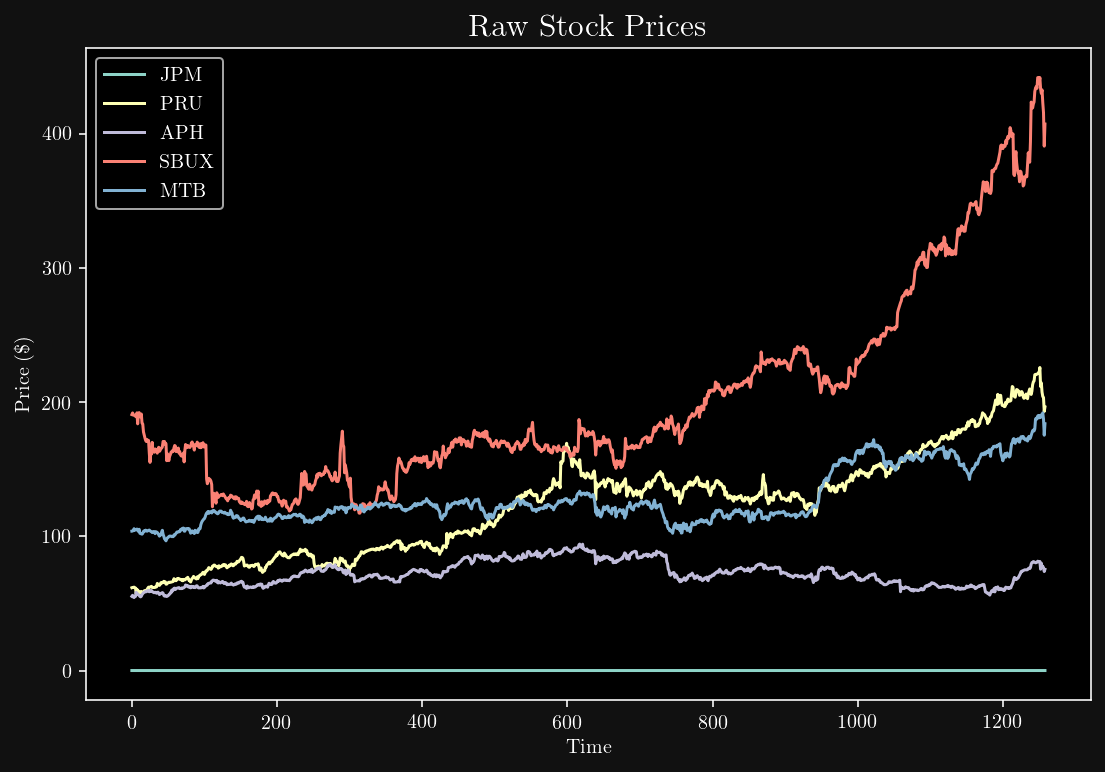

In [21]:
for i in idx:
    plt.plot(prices[i], label=names.values[i])
plt.legend()
plt.title("Raw Stock Prices", fontsize=16)
plt.ylabel("Price (\$)")
plt.xlabel("Time")
plt.show()

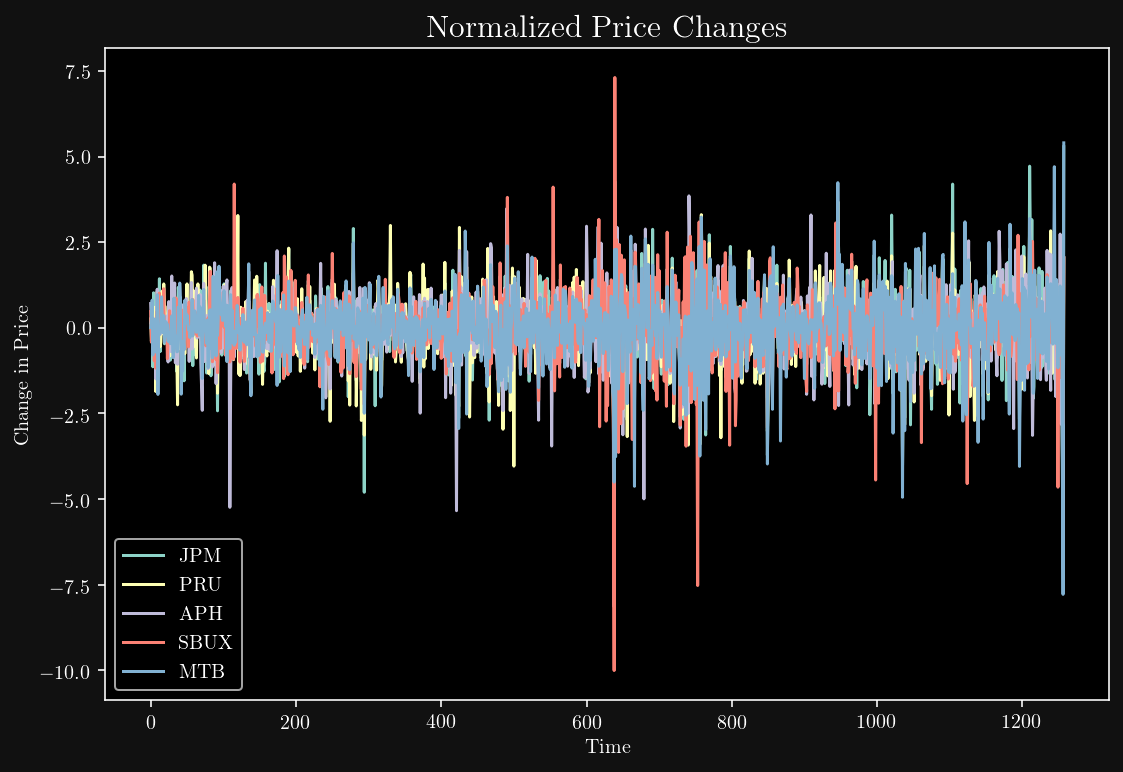

In [34]:
for i in idx:
    plt.plot(normalized_price_changes[i], label=names.values[i])
plt.title("Normalized Price Changes", fontsize=16)
plt.ylabel("Change in Price")
plt.xlabel("Time")
plt.legend()
plt.show()

In [84]:
stock_pca = PCA(n_components=2)
stock_pcs = stock_pca.fit_transform(normalized_price_changes)

In [85]:
stock_pcs.shape

(419, 2)

In [86]:
stock_pca.explained_variance_ratio_

array([0.07722589, 0.03811816])

In [87]:
labels, sectors = pd.factorize(company_info.Sector)
company_info['Sector_ID'] = labels

In [90]:
sectors

Index(['Industrials', 'Health Care', 'Information Technology',
       'Communication Services', 'Consumer Discretionary', 'Utilities',
       'Financials', 'Materials', 'Real Estate', 'Consumer Staples', 'Energy',
       'Communication Services '],
      dtype='object')

In [26]:
ordering = pd.DataFrame(names, columns=['Ticker'])
ordering['order'] = np.arange(ordering.shape[0])

In [27]:
ordering

,Ticker,order
0,XRX,0
1,GS,1
2,SPGI,2
3,MTB,3
4,V,4
...,...,...
501,WFC,414
502,QCOM,415
503,COF,416
504,COG,417


In [40]:
company_info = company_info.merge(ordering, on='Ticker')
company_info[['Ticker', 'order']]

,Ticker,order
0,MMM,248
1,ABT,386
2,ABBV,399
3,ACN,93
4,ATVI,279
...,...,...
414,XYL,22
415,YUM,377
416,ZBH,123
417,ZION,398


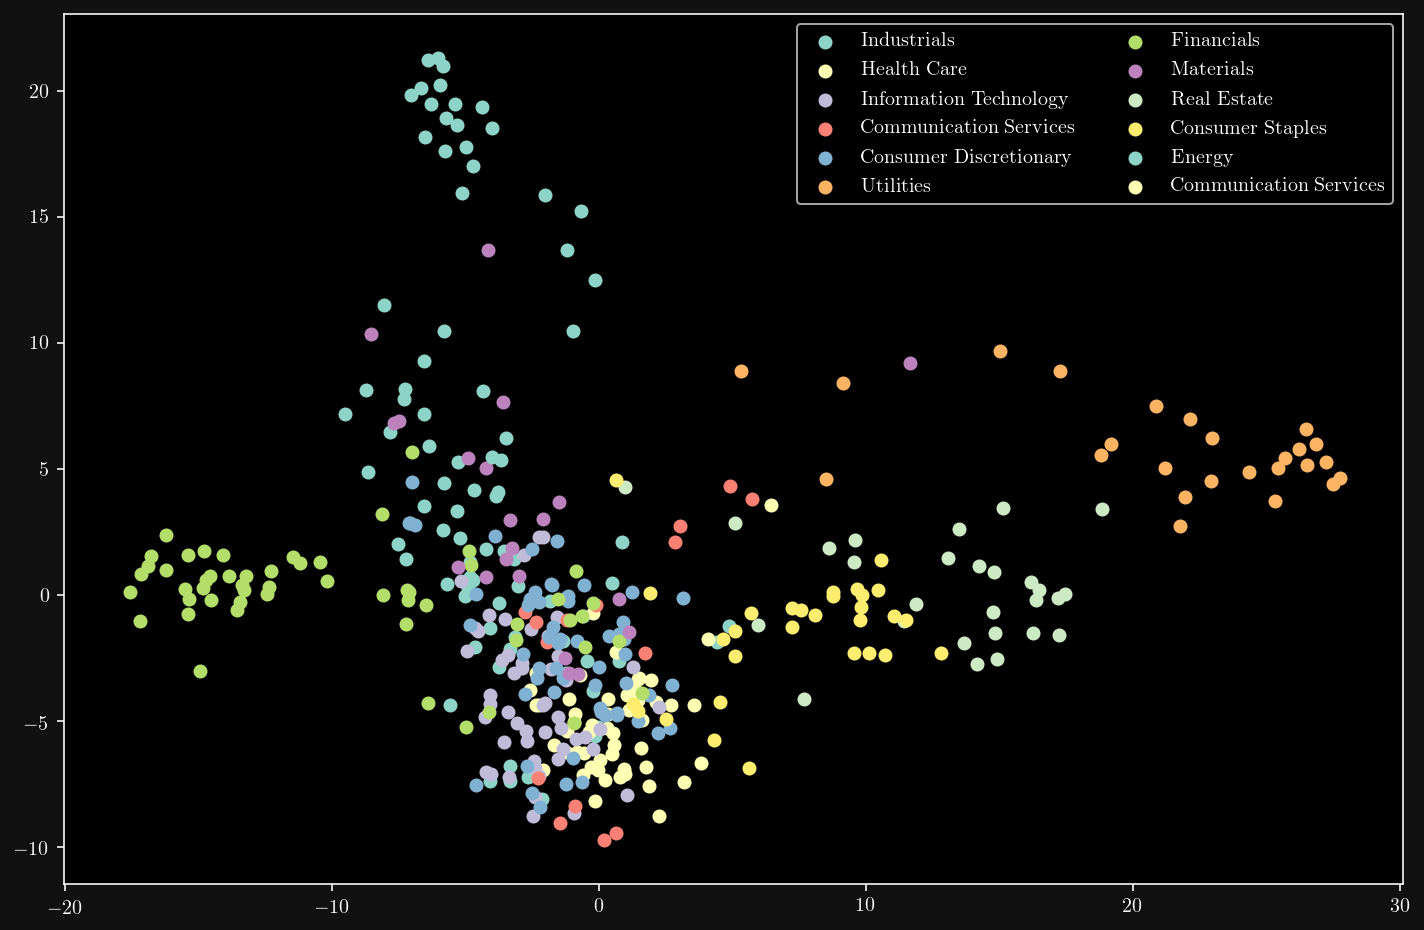

In [29]:
plt.figure(figsize=(12,8))
for i in range(company_info.Sector_ID.max()+1):
    sector_idx = company_info.loc[company_info.Sector_ID==i].order.values
    #print(entry.Sector_ID)
    plt.scatter(stock_pcs[sector_idx,0], stock_pcs[sector_idx,1], label=sectors[i])
#plt.colorbar()
plt.legend(loc='upper right', ncol=2)
plt.show()

### Sklearn makes it easy

Maybe we want to cluster the points. All we need is a few more lines.

In [91]:
from sklearn.cluster import KMeans

In [92]:
kmeans = KMeans(n_clusters=12)

In [93]:
kmeans.fit(stock_pcs)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=12, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [94]:
kmeans.labels_

array([10,  2,  5,  2,  9,  5,  5,  5,  0,  9,  8,  5,  1,  4,  9,  4,  9,
        9, 11, 10,  6,  0, 10,  0,  3,  3,  2,  9,  9,  7, 10,  8, 11,  5,
        2, 10,  9,  6,  5,  2,  5,  9,  0,  6,  5, 10,  8,  8,  2,  5,  9,
        0,  3,  7,  9,  2, 11,  6,  3,  4,  6,  4,  4,  2,  0,  5,  6, 10,
        9, 10, 10,  0,  9,  2,  2,  8,  7,  0,  7, 10,  6,  1,  1,  9,  6,
       11,  1, 10,  0,  2, 10,  1,  7,  5,  2,  6,  6,  5,  5,  6,  9,  6,
        6,  7,  6,  9,  5,  9,  9, 10,  9,  6,  5,  4, 10,  0,  6,  2,  6,
        7,  2,  2,  6,  0, 11,  0,  9,  7,  6,  6,  8,  6, 10,  5,  5,  3,
        3,  5,  5,  7,  5,  0,  6,  9,  9,  3,  1,  3,  1,  9, 10, 10,  9,
        4,  6, 10,  9,  7,  8,  8,  3,  4,  5,  6,  9, 10,  5,  1,  9,  4,
       10,  9,  6,  0,  1,  6,  2, 10,  2,  0,  5,  5,  7, 10,  9,  0,  0,
        1,  9,  1,  3,  4,  6,  0,  7,  5, 10,  0,  8,  4,  9,  1,  2,  5,
        9,  5,  4, 10,  8,  2,  6, 11,  5,  0,  4,  8,  5,  7, 10,  1,  6,
        4,  8,  0,  6,  4

In [95]:
kmeans.cluster_centers_

array([[ -0.21479904,   0.06519237],
       [ 14.65532463,  -0.33113058],
       [-14.3109054 ,   0.51878721],
       [ -4.75528749,  17.99507098],
       [ -6.18408818,   7.11595216],
       [ -2.78548885,  -2.71609481],
       [  1.36452009,  -4.8437957 ],
       [ 23.50781793,   5.3616827 ],
       [  8.00992263,  -0.76322795],
       [ -1.69855638,  -6.89967632],
       [ -5.02393425,   1.54708357],
       [  7.97650811,   6.15431459]])

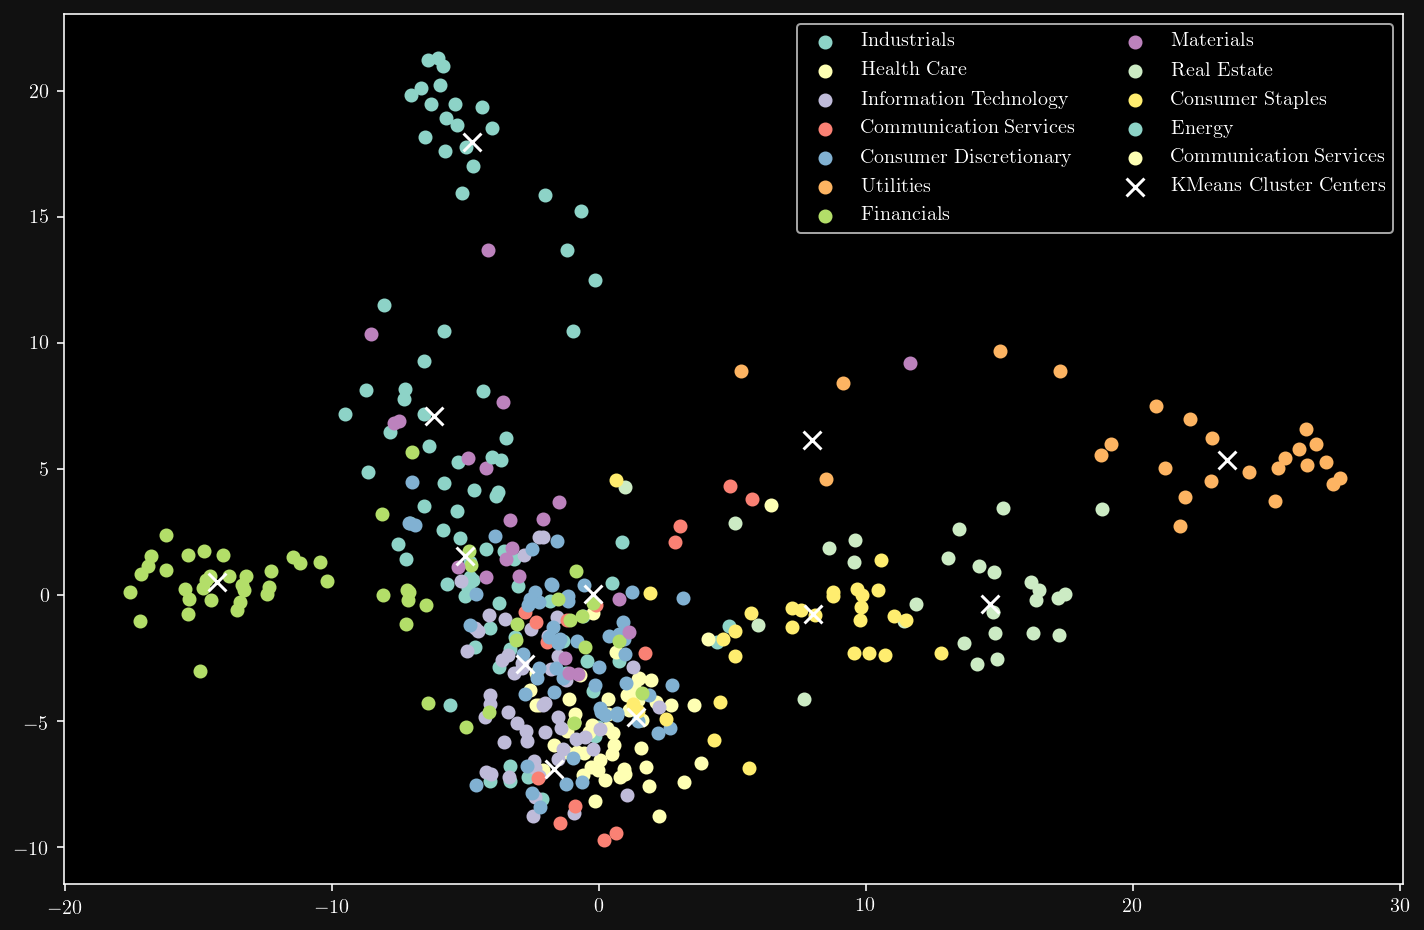

In [96]:
plt.figure(figsize=(12,8))
for i in range(company_info.Sector_ID.max()+1):
    sector_idx = company_info.loc[company_info.Sector_ID==i].order.values
    #print(entry.Sector_ID)
    plt.scatter(stock_pcs[sector_idx,0], stock_pcs[sector_idx,1], label=sectors[i])
#plt.colorbar()
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker='x', c='w', s=80,
           label='KMeans Cluster Centers')
plt.legend(loc='upper right', ncol=2)
plt.show()
